# Step By Step Momentmatching for Gaussian Mixture
- Try to find out where the program breaks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
import gm_funcs
import os

#******Define testing connditions******
np.random.seed(42)  # Set seed for reproducibility
os.environ["LOKY_MAX_CPU_COUNT"] = "12"  # Limit the number of threads used by joblib, windows 11 stuff

# Define leaky ReLU function
def leaky_relu(x, a_in):
    return np.where(x > 0, x, a_in * x)

Parsed Mathematica expressions:
m[0] = w0*(-sqrt(2)*a*c0*exp(-mu0**2/(2*c0**2))/(2*sqrt(pi)) + a*mu0*erfc(sqrt(2)*mu0/(2*c0))/2 + sqrt(2)*c0*exp(-mu0**2/(2*c0**2))/(2*sqrt(pi)) + mu0*(erf(sqrt(2)*mu0/(2*c0)) + 1)/2) + w1*(-sqrt(2)*a*c1*exp(-mu1**2/(2*c1**2))/(2*sqrt(pi)) + a*mu1*erfc(sqrt(2)*mu1/(2*c1))/2 + sqrt(2)*c1*exp(-mu1**2/(2*c1**2))/(2*sqrt(pi)) + mu1*(erf(sqrt(2)*mu1/(2*c1)) + 1)/2)
m[1] = w0*(-sqrt(2)*a**2*c0*mu0*exp(-mu0**2/(2*c0**2))/(2*sqrt(pi)) + a**2*(c0**2 + mu0**2)*erfc(sqrt(2)*mu0/(2*c0))/2 + sqrt(2)*c0*mu0*exp(-mu0**2/(2*c0**2))/(2*sqrt(pi)) + (c0**2 + mu0**2)*(erf(sqrt(2)*mu0/(2*c0)) + 1)/2) + w1*(-sqrt(2)*a**2*c1*mu1*exp(-mu1**2/(2*c1**2))/(2*sqrt(pi)) + a**2*(c1**2 + mu1**2)*erfc(sqrt(2)*mu1/(2*c1))/2 + sqrt(2)*c1*mu1*exp(-mu1**2/(2*c1**2))/(2*sqrt(pi)) + (c1**2 + mu1**2)*(erf(sqrt(2)*mu1/(2*c1)) + 1)/2)
m[2] = w0*(-sqrt(2)*a**3*c0*(2*c0**2 + mu0**2)*exp(-mu0**2/(2*c0**2))/(2*sqrt(pi)) + a**3*mu0*(3*c0**2 + mu0**2)*erfc(sqrt(2)*mu0/(2*c0))/2 + sqrt(2)*c0*(2*c0**2 

## First Step: Define a GM, Compute its Moments in differtent ways
- This serves as a verification of the different ways to compute the moments

*****Moment Comparison*****
Order 1, Samples: 4.0001, Analytic : 4.0000, Pseudo Analytic: 4.0000
Rel. Error: 0.00%, Pseudo Rel. Error: 0.00%
Order 2, Samples: 20.9914, Analytic : 21.0000, Pseudo Analytic: 21.0000
Rel. Error: 0.04%, Pseudo Rel. Error: 0.04%
Order 3, Samples: 114.3113, Analytic : 114.4000, Pseudo Analytic: 114.4000
Rel. Error: 0.08%, Pseudo Rel. Error: 0.08%
Order 4, Samples: 646.7567, Analytic : 647.4800, Pseudo Analytic: 647.4800
Rel. Error: 0.11%, Pseudo Rel. Error: 0.11%
Order 5, Samples: 3780.9093, Analytic : 3786.4000, Pseudo Analytic: 3786.4000
Rel. Error: 0.15%, Pseudo Rel. Error: 0.15%
Order 6, Samples: 22775.8535, Analytic : 22816.7600, Pseudo Analytic: 22816.7600
Rel. Error: 0.18%, Pseudo Rel. Error: 0.18%
Order 7, Samples: 141039.9067, Analytic : 141345.7600, Pseudo Analytic: 141345.7600
Rel. Error: 0.22%, Pseudo Rel. Error: 0.22%
Order 8, Samples: 896067.9555, Analytic : 898389.4160, Pseudo Analytic: 898389.4160
Rel. Error: 0.26%, Pseudo Rel. Error: 0.26%
Or

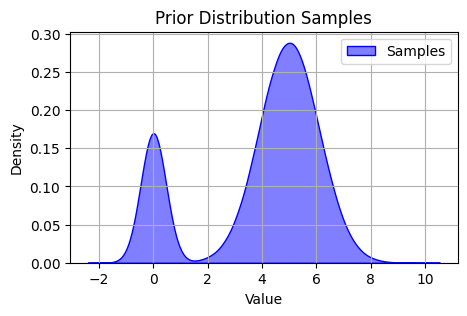

In [2]:
# Parameters for the prior Gaussian Mixture with two components
# c is the variance of the Gaussians, mu are the means of the GM, w are the weights of the GLM
c0_test = 0.2
c1_test = 1.2
mu0_test = 0.0
mu1_test = 5.0
w0_test = 0.2
w1_test = 0.8

#Assemble parameter arrays
mu_test = np.array([mu0_test, mu1_test])
c_test = np.array([c0_test, c1_test])
w_test = np.array([w0_test, w1_test])

# Sample from the Distribution and compare the empirical moments with the analytical ones
num_samples = 1000000
gm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
gm.means_ = np.array([[mu0_test], [mu1_test]])
gm.covariances_ = np.array([[[c0_test]], [[c1_test]]])
gm.weights_ = np.array([w0_test, w1_test])
samples_prior  = gm.sample(num_samples)[0]

# Compute the prior moments empirically
moments_samples_prior = []
for i in range(1, 11):
    moment = np.mean(samples_prior ** i)
    moments_samples_prior.append(moment)

# Compute the first moments analytically
moments_analytic_prior = []
for i in range(1, 11):
    moments_analytic_prior.append(getattr(gm_funcs, f"e{i}_gm")(w_test, mu_test, c_test))

# Check with analytics Computation through linear relu
# Compute the first moments analytically
moments_analytic_prior_leaky = gm_funcs.compute_moments_analytic(1.0,c0_test,c1_test,mu0_test,mu1_test,w0_test,w1_test)
#moments_analytic_prior_leaky = gm_funcs.compute_moments_analytic(1.0,np.sqrt(c0_test),np.sqrt(c1_test),mu0_test,mu1_test,w0_test,w1_test)

print("*****Moment Comparison*****")
for i in range(1, 11):
    print(f"Order {i}, Samples: {moments_samples_prior[i-1]:.4f}, Analytic : {moments_analytic_prior[i-1]:.4f}, Pseudo Analytic: {moments_analytic_prior_leaky[i-1]:.4f}")
    print(f"Rel. Error: {abs(moments_samples_prior[i-1] - moments_analytic_prior[i-1])/abs(moments_samples_prior[i-1]) * 100:.2f}%, Pseudo Rel. Error: {abs(moments_samples_prior[i-1] - moments_analytic_prior_leaky[i-1])/abs(moments_samples_prior[i-1]) * 100:.2f}%")

plt.figure(figsize=(5, 3))
sns.kdeplot(samples_prior.squeeze(), color='blue', label='Samples', fill=True, alpha=0.5)
plt.title('Prior Distribution Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()


## Propagate samples through leaky relu 
- Compute the propagated Moments analytically using LOTUS result from Mathematica
- Match the Moments of a Gaussian Mixture using a Least Square Optimization procedure

Start Moment matching...
Moment Matching Finished! Optimization Time: 0.11981916427612305 seconds

Start EM optimization...
EM Optimization finished! EM Optimization Time: 1.2500262260437012 seconds

***Comparison of optimized Parameters***
Attention! Can be swapped regarding indices
w0:
mm: 0.1999 em: 0.8026
mu0:
mm: 0.1761 em: 4.9869
mu1:
mm: 4.9997 em: 0.1679
c0:
mm: 0.0609 em: 1.2385
c1:
mm: 1.2002 em: 0.0582

Elapsed times: 0.12 seconds for moment matching, 1.25 seconds for EM optimization
MM is 10.43 times faster than EM!


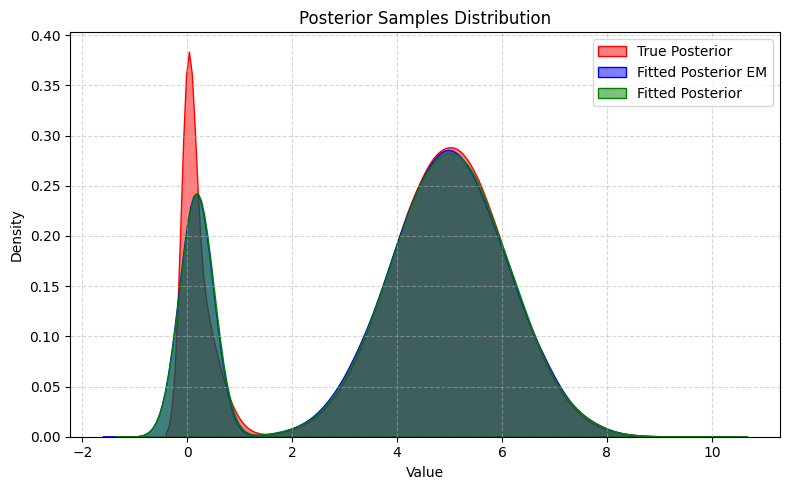

In [3]:
# Compute the propagated samples
a_test = 0.0
samples_post = leaky_relu(samples_prior, a_test)  # Apply leaky ReLU to the samples

# Compute the moments of the samples after applying leaky ReLU analytically (uses MAthematica Results)
moments_analytic_post = gm_funcs.compute_moments_analytic(a_test, c0_test, c1_test, mu0_test, mu1_test, w0_test, w1_test)

# Based on analytic moments, perform moment matching
# Initial guess for x, mu, c (This is important, we can produce suboptimal results)
mu00 = 0.0
mu11 =1.0
w00 = 0.5
w11 = 0.5
c0 = 1.0
c1 = 1.0
# Assemble initial parameters
params0 = [w00, mu00, mu11, c0, c1]
# Define Target moments
args = tuple(moments_analytic_post)

# Call moment based optimizer 
print("Start Moment matching...")
start = time.time()
result = gm_funcs.fit_gm_moments(params0, args)
end = time.time()
time_mm = end - start
print("Moment Matching Finished! Optimization Time:", time_mm, "seconds")
print("")

# Generate GM Samples with optimized parameters
gm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
gm.means_ = np.array([[result.x[1]], [result.x[2]]])
gm.covariances_ = np.array([[[result.x[3]]], [[result.x[4]]]])
gm.weights_ = np.array([result.x[0], 1 - result.x[0]])
samples_post_fitted  = gm.sample(100000)[0]

# Call EM based optimizer on samples
print("Start EM optimization...")
start = time.time()
gm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
gm.fit(samples_post)
end = time.time()
time_em = end - start
print("EM Optimization finished! EM Optimization Time:",time_em, "seconds")
print("")
samples_post_fitted_EM = gm.sample(100000)[0]

# Extract parameters from the EM-fitted Gaussian Mixture Model
em_weights = gm.weights_
em_means = gm.means_.flatten()
em_covariances = gm.covariances_.flatten()
print("***Comparison of optimized Parameters***")
print("Attention! Can be swapped regarding indices")
print("w0:")
print("mm:", f"{result.x[0]:.4f}", "em:", f"{em_weights[0]:.4f}")
print("mu0:")
print("mm:", f"{result.x[1]:.4f}", "em:", f"{em_means[0]:.4f}")
print("mu1:")
print("mm:", f"{result.x[2]:.4f}", "em:", f"{em_means[1]:.4f}")
print("c0:")
print("mm:", f"{result.x[3]:.4f}", "em:", f"{em_covariances[0]:.4f}")
print("c1:")
print("mm:", f"{result.x[4]:.4f}", "em:", f"{em_covariances[1]:.4f}")
print("")
print(f"Elapsed times: {time_mm:.2f} seconds for moment matching, {time_em:.2f} seconds for EM optimization")
print(f"MM is {time_em / time_mm:.2f} times faster than EM!")

# Plot posterior samples as a KDE with filled areas and different colors
plt.figure(figsize=(8, 5))
sns.kdeplot(samples_post.squeeze(), color='red', label='True Posterior', fill=True, alpha=0.5)
sns.kdeplot(samples_post_fitted_EM.squeeze(), color='blue', label='Fitted Posterior EM', fill=True, alpha=0.5)
sns.kdeplot(samples_post_fitted.squeeze(), color='green', label='Fitted Posterior', fill=True, alpha=0.5)
plt.title('Posterior Samples Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.savefig('workbench/momentmatching_postReLU.png', dpi=300)


- Try to show local miminum structure in the residuals regarding the mean of the first gauss

In [4]:
# Set initial state
# Good Result
#mu00 = 0.0
mu11 =5.0
w00 = 0.2
# w11 = 0.8
c0 = 0.06
c1 = 1.2

#Bad Result
# mu11 = 5.41
# w00 = 0.43
# # w11 = 0.5
# c0 = 4.59
# c1 = 0.69

# Define range of mean we want to vary
mu_range = np.linspace(-1, 5, 100)
params_list = [[w00, mu, mu11, c0, c1] for mu in mu_range]
args = moments_analytic_post

#Compute residuals for diefferent parameters
residuals = []
for param in params_list:
    residuals.append(gm_funcs.residuals_weighted(param, *args))

residuals = np.array(residuals)

# Squared Residual sum
residuals_squared = np.sum(residuals**2, axis=1)

# plt.figure(figsize=(8, 5))
# for i in range(residuals.shape[1]):
#     plt.plot(mu_range, residuals[:,i], label=f'Residuals {i+1}')
# plt.legend()

# plt.figure(figsize=(8, 5))
# plt.plot(mu_range, residuals_squared, label='Squared Residuals', color='red')
# min_index = np.argmin(residuals_squared)
# min_mu = mu_range[min_index]
# plt.axvline(x=min_mu, color='blue', linestyle='--', label=f'Minimum at {min_mu:.2f}')
# plt.scatter(min_mu, residuals_squared[min_index], color='red', label=f'Min Value: {residuals_squared[min_index]:.8f}')
# plt.title('Residuals vs. Mean')
# plt.legend()

## Approximate arbitrary GM based on Moments

Start Moment matching...
Moment Matching Finished! Optimization Time: 0.0020055770874023438 seconds

Optimized Weights: 0.7999998134519821 0.20000018654801788
Optimized Means: 5.000000454871537 2.845586572685861e-06
Optimized Covariances: 1.1999995242792063 0.020008124620432718


Text(0, 0.5, 'Density')

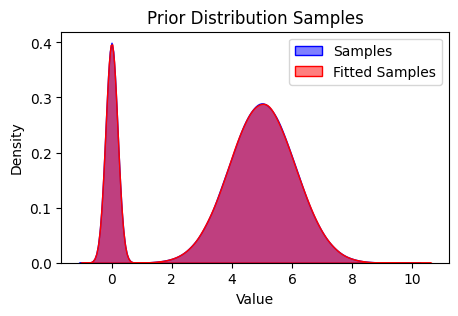

In [5]:
# Parameters for the prior Gaussian Mixture with two components
# c is the variance of the Gaussians, mu are the means of the GM, w are the weights of the GLM
c0_test = 0.02
c1_test = 1.2
mu0_test = 0.0
mu1_test = 5.0
w0_test = 0.2
w1_test = 0.8

# Assemble parameter arrays
mu_test = np.array([mu0_test, mu1_test])
c_test = np.array([c0_test, c1_test])
w_test = np.array([w0_test, w1_test])

# Sample from the Distribution and compare the empirical moments with the analytical ones
num_samples = 1000000
gm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
gm.means_ = np.array([[mu0_test], [mu1_test]])
gm.covariances_ = np.array([[[c0_test]], [[c1_test]]])
gm.weights_ = np.array([w0_test, w1_test])
samples_prior  = gm.sample(num_samples)[0]

# Compute the first moments analytically
moments_analytic_test = []
for i in range(1, 11):
    moments_analytic_test.append(getattr(gm_funcs, f"e{i}_gm")(w_test, mu_test, c_test))

# Perform the fit
# Initial guess for x, mu, c
mu00 = 4.98
mu11 = 0.15
w00 = 0.8
w11 = 0.2
c0 = 1.23
c1 = 0.06
params0 = [w00, mu00, mu11, c0, c1]
args = tuple(moments_analytic_test)

# Call moment based optimizer 
print("Start Moment matching...")
start = time.time()
result = gm_funcs.fit_gm_moments(params0, args)
end = time.time()
print("Moment Matching Finished! Optimization Time:", end - start, "seconds")
print("")
print("Optimized Weights:", result.x[0], 1-result.x[0])
print("Optimized Means:", result.x[1], result.x[2])
print("Optimized Covariances:", result.x[3], result.x[4])

# Sample from a GM model
gm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
gm.means_ = np.array([[result.x[1]], [result.x[2]]])
gm.covariances_ = np.array([[[result.x[3]]], [[result.x[4]]]])
gm.weights_ = np.array([result.x[0], 1 - result.x[0]])
samples_prior_fitted  = gm.sample(num_samples)[0]

plt.figure(figsize=(5, 3))
sns.kdeplot(samples_prior.squeeze(), color='blue', label='Samples', fill=True, alpha=0.5)
sns.kdeplot(samples_prior_fitted.squeeze(), color='red', label='Fitted Samples', fill=True, alpha=0.5)
plt.title('Prior Distribution Samples')
plt.xlabel('Value')
plt.legend()
plt.ylabel('Density')

# Approximate a 4 Component Gaussian Mixture based on Moments
- Generate an arbitrary Gm and compute its Moments
- Match the moments of a smaller GM

Start Moment matching...
Moment Matching Finished! Optimization Time: 0.008384943008422852 seconds

Optimized Weights: 0.7962171741915096 0.2037828258084904
Optimized Means: 8.514188182726958 1.5742567259357167
Optimized Covariances: 0.27318394179768146 0.5483191492221053


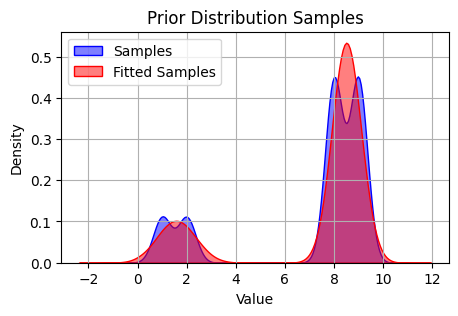

In [6]:
# Define 4 component GM Parameters
w_def = np.array([0.1, 0.1, 0.4, 0.4])	
mu_def = np.array([1, 2, 8.0, 9])
c_def = np.array([0.05, 0.05, 0.05, 0.05])

# Sample form the GMM
num_samples = 100000
gm = sklearn.mixture.GaussianMixture(n_components=4, covariance_type='full')
gm.means_ = np.array([[mu_def[0]], [mu_def[1]], [mu_def[2]], [mu_def[3]]])
gm.covariances_ = np.array([[[c_def[0]]], [[c_def[1]]], [[c_def[2]]], [[c_def[3]]]])
gm.weights_ = np.array([w_def[0], w_def[1], w_def[2], w_def[3]])
samples_prior  = gm.sample(num_samples)[0]

# COmpute the analytical moments of the 4 Component GM with its parameters
moments_analytic_prior = []
moments_analytic_prior.append(gm_funcs.e1_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e2_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e3_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e4_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e5_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e6_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e7_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e8_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e9_gm(w_def,mu_def,c_def))
moments_analytic_prior.append(gm_funcs.e10_gm(w_def,mu_def,c_def))

# Fit a 2 Component GM to the moments
params0 = [0.5, 1.0, 0.5, 1.0, 1.0]
args = tuple(moments_analytic_prior)
print("Start Moment matching...")
start = time.time()
result = gm_funcs.fit_gm_moments(params0, args)
end = time.time()
print("Moment Matching Finished! Optimization Time:", end - start, "seconds")
print("")
print("Optimized Weights:", result.x[0], 1-result.x[0])
print("Optimized Means:", result.x[1], result.x[2])
print("Optimized Covariances:", result.x[3], result.x[4])

# Draw samples fropm the fitted two component GM
gm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
gm.means_ = np.array([[result.x[1]], [result.x[2]]])
gm.covariances_ = np.array([[[result.x[3]]], [[result.x[4]]]])
gm.weights_ = np.array([result.x[0], 1 - result.x[0]])
samples_prior_fitted  = gm.sample(num_samples)[0]

# Plot it
plt.figure(figsize=(5, 3))
sns.kdeplot(samples_prior.squeeze(), color='blue', label='Samples', fill=True, alpha=0.5)
sns.kdeplot(samples_prior_fitted.squeeze(), color='red', label='Fitted Samples', fill=True, alpha=0.5)
plt.title('Prior Distribution Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
